In [2]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

pd.get_option("max_info_columns")

100

In [3]:
pd.set_option("display.max_info_columns", 300) 

gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4835 non-null   object  
 1   LSOA11NM   4835 non-null   object  
 2   MSOA11CD   4835 non-null   object  
 3   MSOA11NM   4835 non-null   object  
 4   LAD11CD    4835 non-null   object  
 5   LAD11NM    4835 non-null   object  
 6   RGN11CD    4835 non-null   object  
 7   RGN11NM    4835 non-null   object  
 8   USUALRES   4835 non-null   int64   
 9   HHOLDRES   4835 non-null   int64   
 10  COMESTRES  4835 non-null   int64   
 11  POPDEN     4835 non-null   float64 
 12  HHOLDS     4835 non-null   int64   
 13  AVHHOLDSZ  4835 non-null   float64 
 14  geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [4]:
df = pd.read_csv('https://data.london.gov.uk/download/lsoa-atlas/0193f884-2ccd-49c2-968e-28aa3b1c480d/lsoa-data.csv',
                 encoding= 'unicode_escape', na_values=[':'], low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 277 columns):
 #   Column                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                            --------------  -----  
 0   Lower Super Output Area                                                                                           4835 non-null   object 
 1   Names                                                                                                             4835 non-null   object 
 2   Mid-year Population Estimates;All Ages;2001                                                                       4835 non-null   float64
 3   Mid-year Population Estimates;All Ages;2002                                                                       4835 non-null   float64
 4   Mid-year Population Estimates

In [6]:
df = df[['Lower Super Output Area','Ethnic Group;White (%);2011','Ethnic Group;Mixed/multiple ethnic groups (%);2011','Ethnic Group;Asian/Asian British (%);2011',
        'Ethnic Group;Black/African/Caribbean/Black British (%);2011','Ethnic Group;Other ethnic group (%);2011']]
df.head()

Lower Super Output Area  Ethnic Group;White (%);2011  \
0               E01000907                         73.5   
1               E01000908                         72.4   
2               E01000909                         84.1   
3               E01000912                         77.3   
4               E01000913                         88.2   

   Ethnic Group;Mixed/multiple ethnic groups (%);2011  \
0                                                7.3    
1                                                8.7    
2                                                5.5    
3                                                5.6    
4                                                5.1    

   Ethnic Group;Asian/Asian British (%);2011  \
0                                        8.5   
1                                        6.2   
2                                        4.6   
3                                        5.1   
4                                        4.7   

   Ethnic Group;Black/African/Caribbean/Black British (%);2011  \
0                                                7.9             
1                                                8.0             
2                                                2.9             
3                                                9.2             
4                                                1.3             

   Ethnic Group;Other ethnic group (%);2011  
0                                       2.8  
1                                       4.7  
2                                       2.9  
3                                       2.8  
4                                       0.7

In [8]:
df.columns = ['lsoa','White','Mixed','Asian','Black','Others']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lsoa    4835 non-null   object 
 1   White   4835 non-null   float64
 2   Mixed   4835 non-null   float64
 3   Asian   4835 non-null   float64
 4   Black   4835 non-null   float64
 5   Others  4835 non-null   float64
dtypes: float64(5), object(1)
memory usage: 226.9+ KB


In [9]:
pd.isnull(df).sum() > 0

lsoa      True
White     True
Mixed     True
Asian     True
Black     True
Others    True
dtype: bool

In [10]:
print(df[df['White'].isnull()])

     lsoa  White  Mixed  Asian  Black  Others
4835  NaN    NaN    NaN    NaN    NaN     NaN
4836  NaN    NaN    NaN    NaN    NaN     NaN


In [11]:
print(df[df['Others'].isnull()])

     lsoa  White  Mixed  Asian  Black  Others
4835  NaN    NaN    NaN    NaN    NaN     NaN
4836  NaN    NaN    NaN    NaN    NaN     NaN


In [12]:
print(df.shape)

df = df.dropna()

print(df.shape)

(4837, 6)
(4835, 6)


In [13]:
ppd = pd.merge(gdf, df, left_on='LSOA11CD', right_on='lsoa', how='inner').reset_index()
ppd.shape
ppd.sample(3)

index   LSOA11CD            LSOA11NM   MSOA11CD           MSOA11NM  \
669     669  E01000684        Bromley 035D  E02000161        Bromley 035   
329     329  E01000334         Bexley 006A  E02000070         Bexley 006   
4680   4680  E01032764  Tower Hamlets 004E  E02000867  Tower Hamlets 004   

        LAD11CD        LAD11NM    RGN11CD RGN11NM  USUALRES  ...  POPDEN  \
669   E09000006        Bromley  E12000007  London      2036  ...    50.6   
329   E09000004         Bexley  E12000007  London      1611  ...    60.8   
4680  E09000030  Tower Hamlets  E12000007  London      1302  ...    40.0   

      HHOLDS  AVHHOLDSZ                                           geometry  \
669      757        2.7  POLYGON ((546012.455 164967.614, 546171.471 16...   
329      640        2.5  POLYGON ((548802.410 178204.611, 548806.000 17...   
4680     643        2.0  POLYGON ((537326.192 184202.446, 537371.092 18...   

           lsoa White Mixed  Asian  Black  Others  
669   E01000684  83.7   2.0    9.4    3.7     1.2  
329   E01000334  78.6   2.0    9.3    8.9     1.2  
4680  E01032764  64.7   5.5   19.2    7.3     3.2  

[3 rows x 22 columns]

In [14]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [15]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

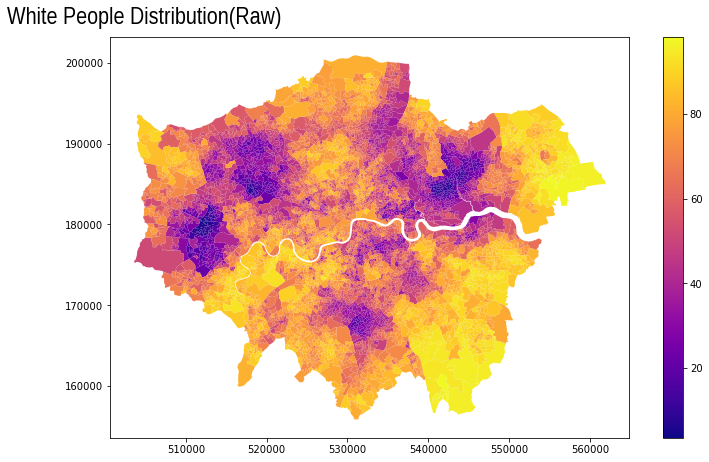

In [16]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='White', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"White People Distribution(Raw)", x=0.025, size=24, **tfont);

In [17]:
ppd = ppd[['LSOA11NM','LSOA11CD','geometry','White','Mixed','Asian','Black','Others']].copy()
ppd.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry  White  Mixed  Asian  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...   84.5    3.7    8.7   
1  POLYGON ((532746.813 181786.891, 532671.688 18...   88.7    3.8    6.6   
2  POLYGON ((532135.145 182198.119, 532158.250 18...   78.4    4.1   12.5   
3  POLYGON ((533807.946 180767.770, 533649.063 18...   51.4    6.0   27.8   
4  POLYGON ((545122.049 184314.931, 545271.917 18...   32.7    3.4   50.6   

   Black  Others  
0    0.8     2.3  
1    0.3     0.6  
2    3.3     1.7  
3   10.2     4.7  
4   10.4     2.9

In [18]:
to_cluster = ppd[['LSOA11CD','White','Mixed','Asian','Black','Others']].set_index('LSOA11CD').copy()
to_cluster.head()

White  Mixed  Asian  Black  Others
LSOA11CD                                     
E01000001   84.5    3.7    8.7    0.8     2.3
E01000002   88.7    3.8    6.6    0.3     0.6
E01000003   78.4    4.1   12.5    3.3     1.7
E01000005   51.4    6.0   27.8   10.2     4.7
E01000006   32.7    3.4   50.6   10.4     2.9

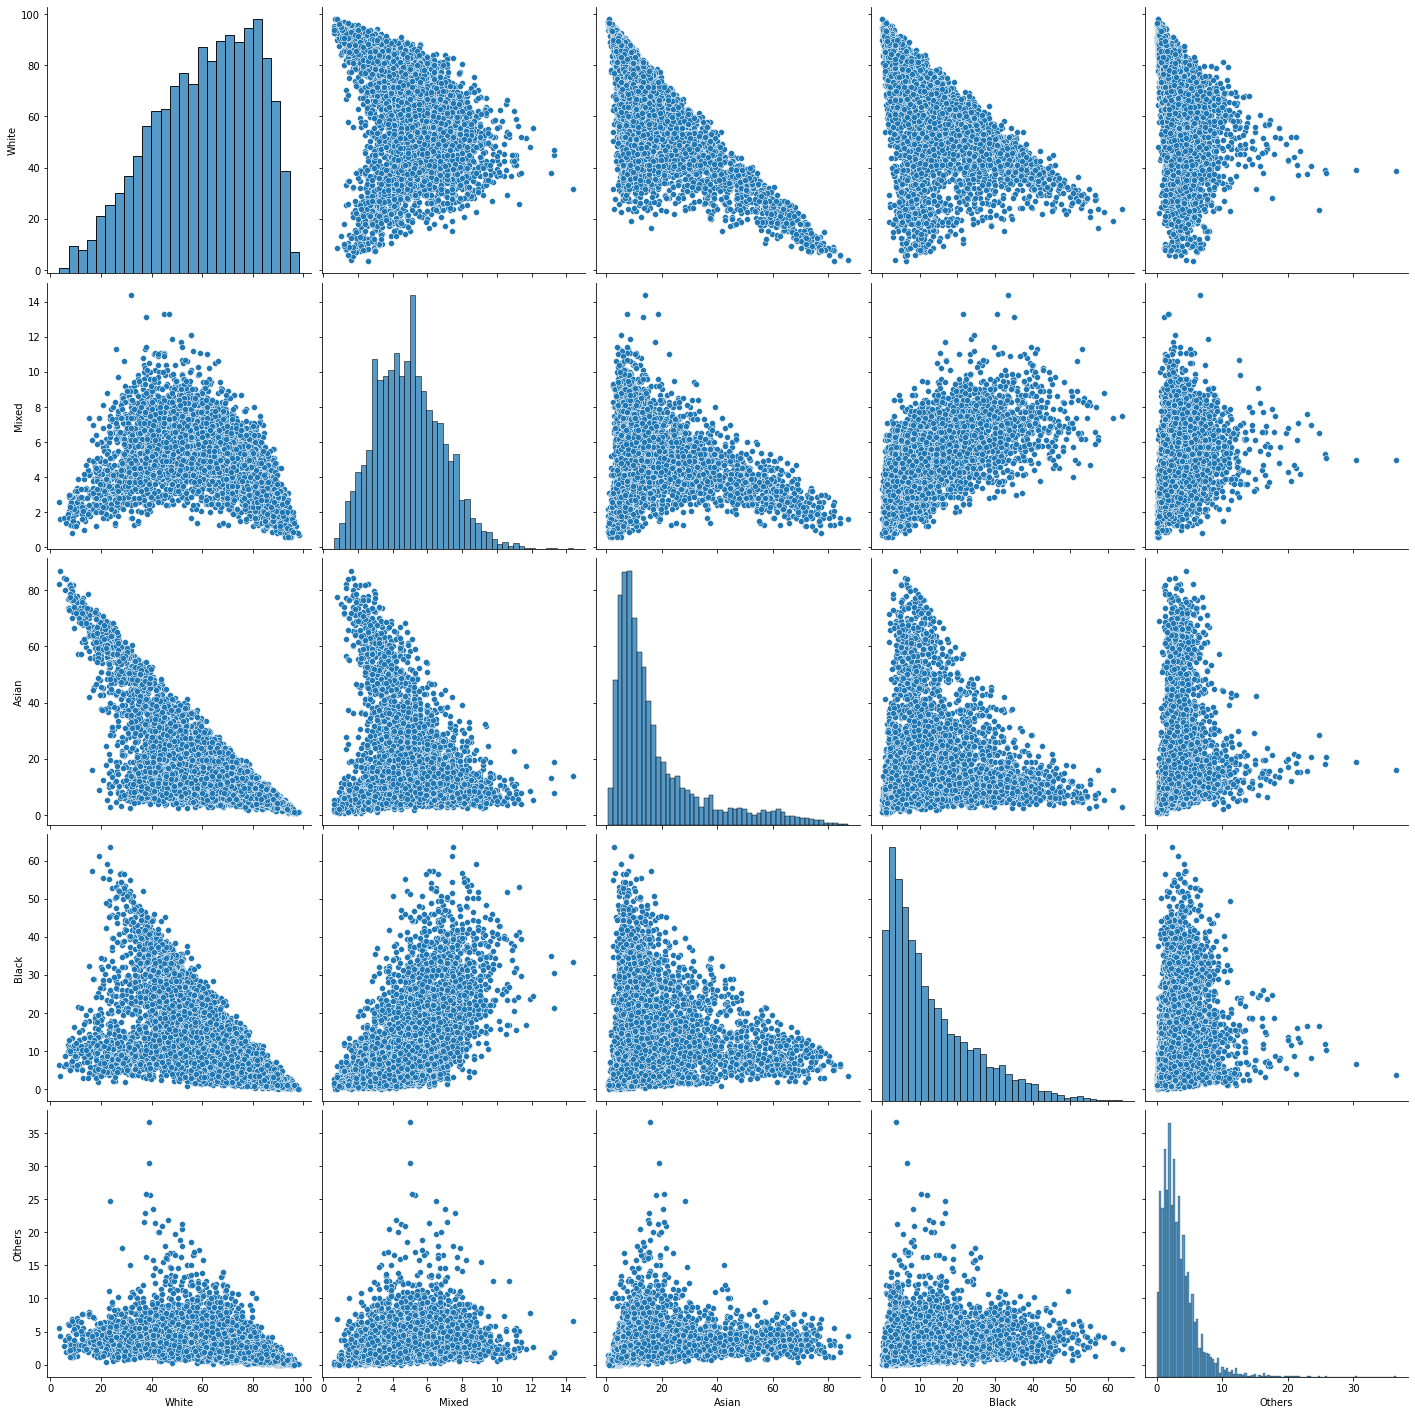

In [19]:
plot_norm = sns.pairplot(to_cluster,height = 4)

In [20]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.sample(5)

White     Mixed     Asian     Black    Others
LSOA11CD                                                   
E01003851  1.623428 -1.053734 -1.396382 -2.244516 -1.228349
E01032567  0.045460  0.366447 -0.171095  0.818067 -0.861609
E01002307  1.542050 -1.441070 -2.316091 -0.646498 -1.831322
E01000843  0.486603  0.653105  0.034094 -0.317966  0.111614
E01002161 -1.358180 -0.035999  1.616112 -0.033153  0.365451

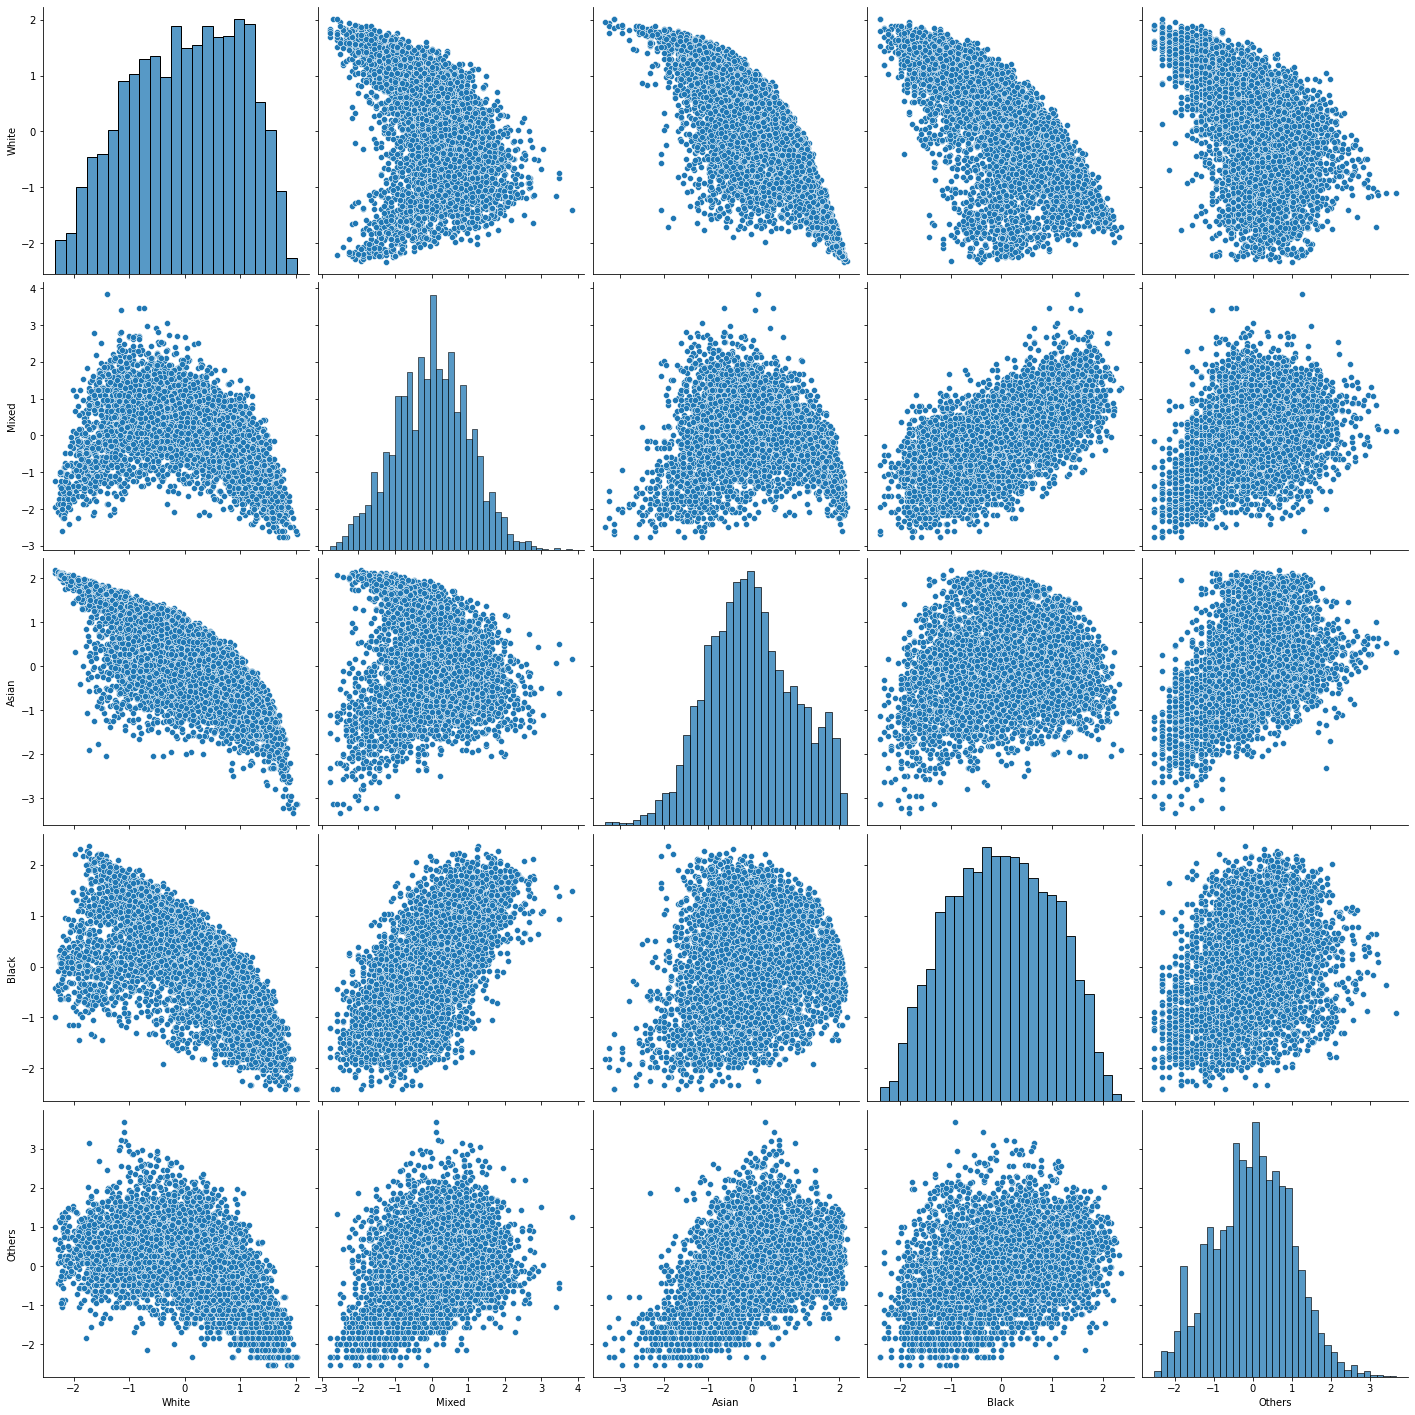

In [21]:
plot_norm = sns.pairplot(normed,height = 4)

In [22]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.54363183 0.25429391 0.12695866 0.06272946 0.01238613]


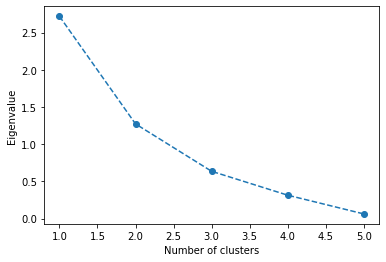

In [23]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [24]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.54363183 0.25429391]


In [25]:
list_var = normed.columns.tolist()
print(list_var)

['White', 'Mixed', 'Asian', 'Black', 'Others']


In [27]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

White     Mixed     Asian     Black    Others
0  0.554062 -0.367542 -0.381999 -0.468373 -0.438898
1 -0.231939 -0.608092  0.638084 -0.401560  0.089596

In [28]:
score_pca = pca.transform(normed)
score_pca

array([[ 2.05096153,  0.52869946],
       [ 3.05580285,  0.21163062],
       [ 1.33750026,  0.3725954 ],
       ...,
       [-0.80471607, -0.34906851],
       [-0.96052957, -1.12676588],
       [ 1.79354997, -0.81372695]])

In [29]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[2.71872145 1.27173259]


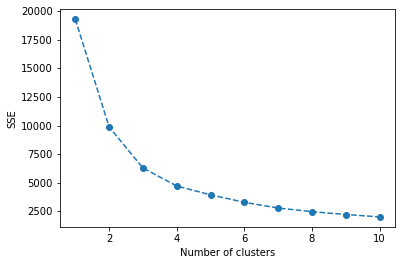

In [30]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [44]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=3, random_state=1)

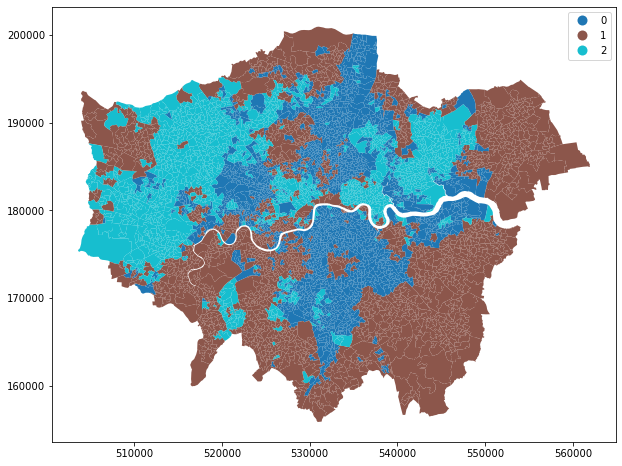

In [45]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [33]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [34]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third',3:'Forth'})

In [34]:
ppd_kpca.head()

LSOA11NM   LSOA11CD  \
0        City of London 001A  E01000001   
1        City of London 001B  E01000002   
2        City of London 001C  E01000003   
3        City of London 001E  E01000005   
4  Barking and Dagenham 016A  E01000006   

                                            geometry  Eco_Active  Eco_inact  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...       964.0      257.0   
1  POLYGON ((532746.813 181786.891, 532671.688 18...       926.0      270.0   
2  POLYGON ((532135.145 182198.119, 532158.250 18...       822.0      280.0   
3  POLYGON ((533807.946 180767.770, 533649.063 18...       530.0      243.0   
4  POLYGON ((545122.049 184314.931, 545271.917 18...       874.0      377.0   

   Employment  Unemployment  Income_Mean  PTAL_Mean  Kmeans_Cluster  \
0        74.9           3.5      74846.0        8.0               1   
1        74.8           1.7      73325.0        8.0               1   
2        67.2           4.7      44130.0        7.3               1   
3        58.9           8.7      30781.0        8.0               0   
4        58.6           9.5      46141.0        6.4               0   

   Component1  Component2  Component3 Segement  
0    2.833068    1.354093   -1.433781   Second  
1    3.271750    1.169787   -1.161903   Second  
2    0.995861    0.721407   -1.645861   Second  
3   -1.182227   -0.975275   -3.678005    First  
4   -0.651584    1.165002   -0.974686    First

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


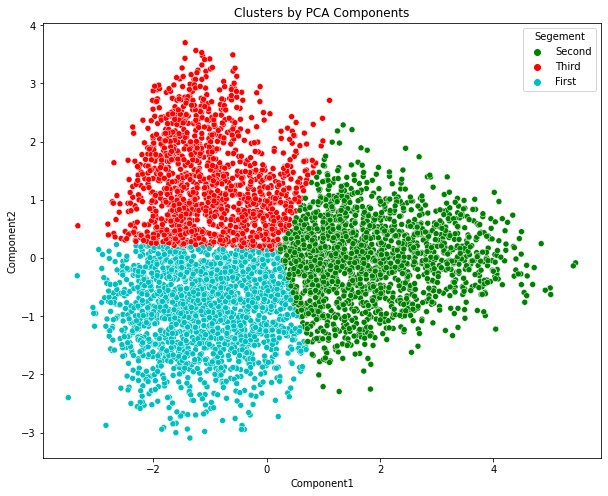

In [36]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r','c'])
plt.title('Clusters by PCA Components')
plt.show()

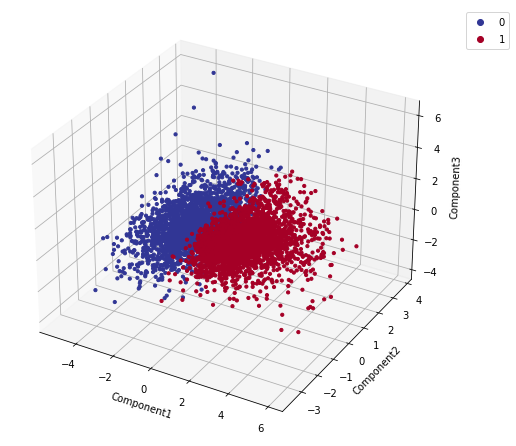

In [36]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("RdYlBu_r", 256).as_hex())

x = ppd_kpca['Component1']
y = ppd_kpca['Component2']
z = ppd_kpca['Component3']

# plot
sc = ax.scatter(x, y, z, s=40, c=ppd_kpca['Kmeans_Cluster'], marker='.', cmap=cmap, alpha=1)
ax.set_xlabel('Component1')
ax.set_ylabel('Component2')
ax.set_zlabel('Component3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

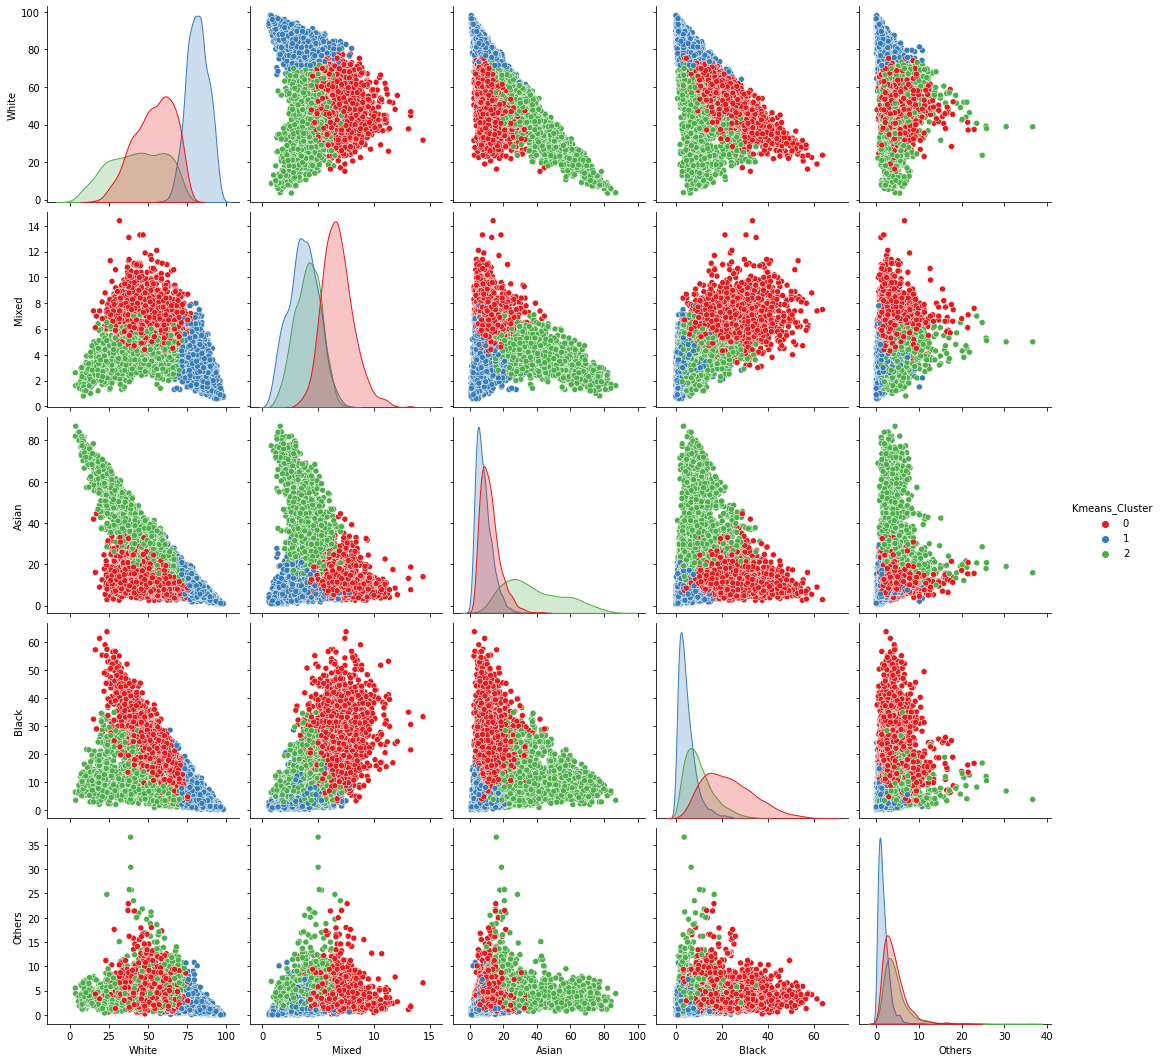

In [46]:
plot_norm = sns.pairplot(ppd,hue = 'Kmeans_Cluster',height = 3,palette = 'Set1')

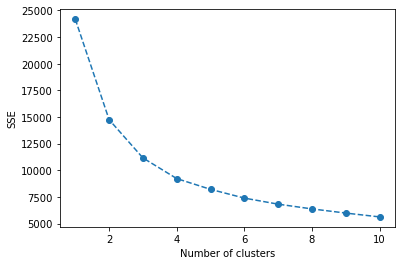

In [38]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(normed)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [39]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=2, random_state=1)

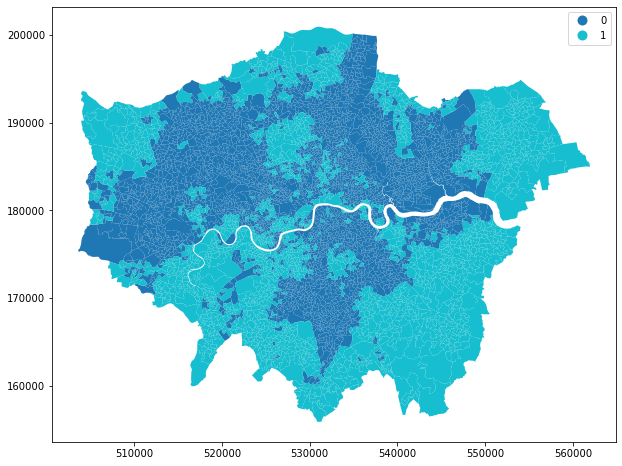

In [40]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

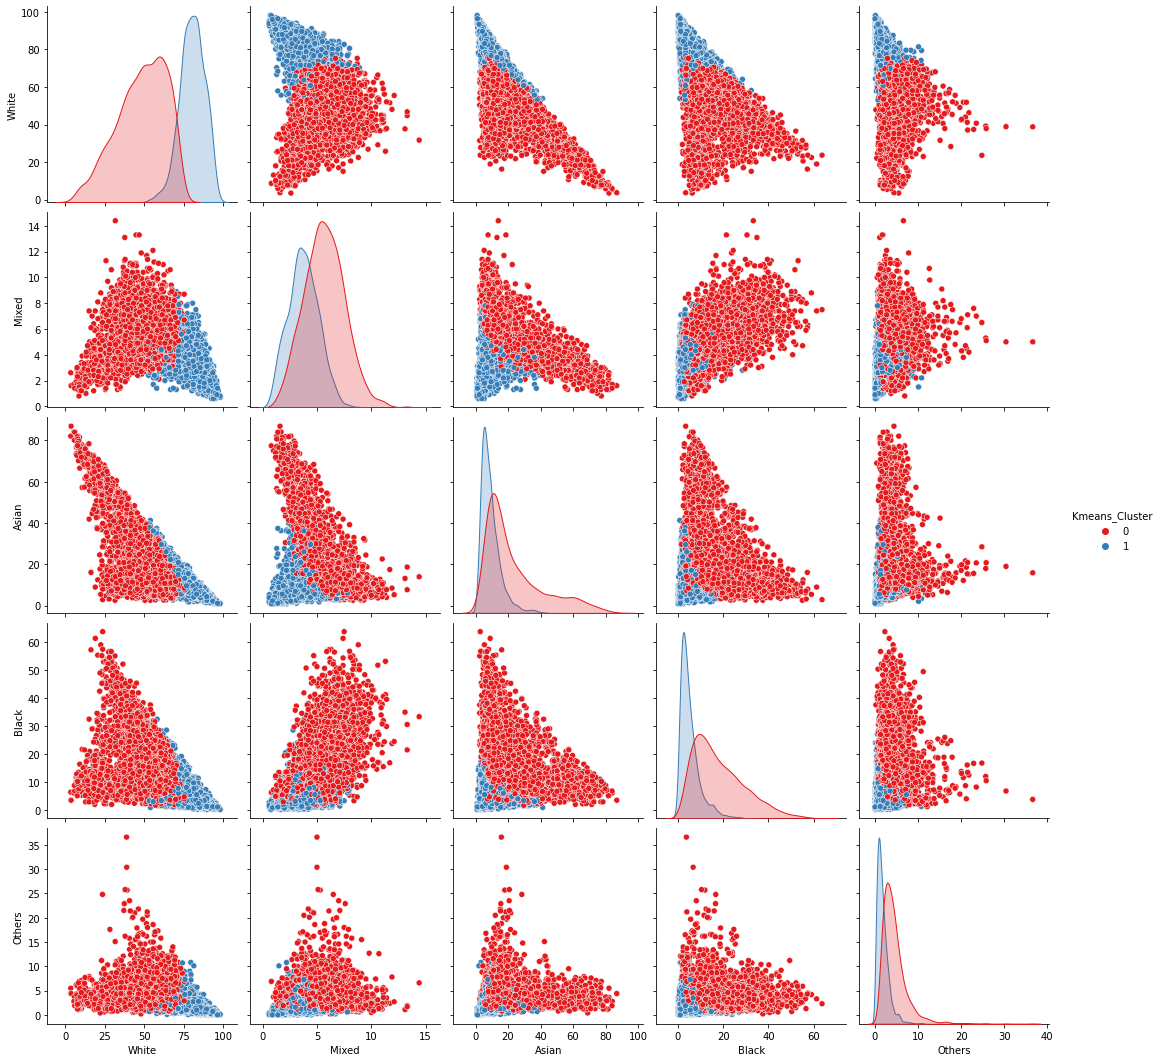

In [41]:
plot_norm = sns.pairplot(ppd,hue = 'Kmeans_Cluster',height = 3,palette = 'Set1')